<a href="https://colab.research.google.com/github/BLRGoD/Econometrics_labs/blob/main/Econometrics_lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from numpy import ones
from pandas import DataFrame
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import norm, kstest
from numpy import arange
from statsmodels.formula.api import ols
from scipy.stats import f

In [ ]:
data = pd.read_excel('lab_4.xlsx', 'python') 
data.head(10)



,Y,x1,x2,x5,x8,x10,x11,x12,x14,x18
0,16659,восточный,17.2,1,лоджия,последний,2.99,панельный,37,2
1,10528,восточный,26.3,1,нет,последний,2.57,панельный,63,2
2,17728,восточный,18.7,1,более одного балкона,промежуточный,2.87,кирпичный,39,1
3,11277,восточный,23.4,1,балкон,промежуточный,2.65,кирпичный,49,1
4,13325,восточный,21.0,1,балкон,последний,2.76,блочный,44,2
5,13577,восточный,19.9,1,нет,промежуточный,2.83,кирпичный,52,3
6,9471,восточный,25.9,1,нет,промежуточный,2.57,панельный,47,2
7,9651,восточный,21.7,1,нет,промежуточный,2.48,кирпичный,48,3
8,16674,восточный,22.9,1,балкон,промежуточный,2.60,кирпичный,51,3
9,14048,восточный,20.9,1,нет,последний,2.61,кирпичный,47,3


In [ ]:
columns = list(['x1','x5','x8', 'x10', 'x12'])
def YX(data_x, response, vars_x):
    nones = DataFrame({'Intercept': ones(data_x.shape[0])})
    X = nones.join(DataFrame(data=data_x.loc[:, vars_x].values, columns=vars_x))
    Y = DataFrame(data=data_x[response].values, columns=[response])
    return Y, X

In [ ]:
dataWitoutFict = data.loc[:, ['Y', 'x2', 'x11', 'x14', 'x18']]

In [ ]:
formula = "{} ~ {}".format("Y", "+".join(dataWitoutFict.drop(columns='Y').columns.to_list()))
print(formula)
model_kol = ols(formula=formula, data=data).fit()
print("\nРезультаты оценки параметров регрессионной модели для всех квартир\n", model_kol.summary())

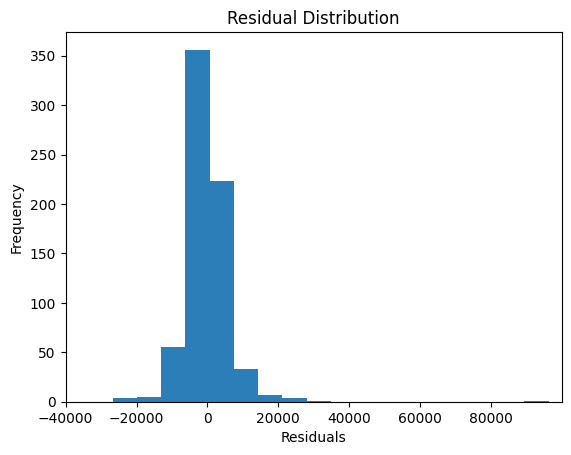

In [ ]:
model_kol = backward_elimination(dataWitoutFict, "Y")
# print("\nРезультаты оценки параметров регрессионной модели для всех квартир после устранения\n"
#       "мультиколлинеарности методом пошаговой регрессии с исключением переменных", model_kol.summary(),
#       sep='\n')
plot_residuals(model_kol.resid)


In [ ]:
for col in columns:
    values = sorted(list(set(data[col])))[:-1]
    for i in range(len(values)):
        data = data.assign(newVariable = lambda x : x[col] == values[i])
        data.newVariable = data.newVariable.apply(int)
        data.rename(columns={'newVariable' : "d_{}_{}".format(col, i + 1)}, inplace=True)
        print("-" * 10)
        print("d_{}_{} = 1, если {} = {}".format(col, i + 1, col, values[i]))
        print("d_{}_{} = 0, иначе".format(col, i + 1)) 
    data = data.drop(columns=[col])
data.head()

In [ ]:
def findRss(data, response):
    Y, X = YX(data, response, data.drop(columns=[response]).columns.tolist())
    reslt = sm.OLS(Y, X).fit()

    return reslt.resid.values @ reslt.resid.values.T, int(reslt.nobs)

In [ ]:
def chowTest(samp1, samp2, response):
    rssTotal = findRss(pd.concat([samp1, samp2]), response)[0]
    rss1, n1 = findRss(samp1, response)
    rss2, n2 = findRss(samp2, response)
    chowNom = (rssTotal - rss1 - rss2) / samp1.shape[1]
    chowDenom = (rss1 + rss2) / (n1 + n2 - 2 * samp1.shape[1])
    return rssTotal, rss1, rss2, chowNom / chowDenom

In [ ]:
def backward_elimination(data_b, response):
    selected = set(data_b.columns)
    selected.remove(response)
    currentPValues = ols(formula="{} ~ {}".format(response, " + ".join(selected)), data=data_b).fit().pvalues
    for _ in range(len(data_b.columns)):
        currentAdjR2 = -1.3
        if max(currentPValues) >= 0.05:
            for i in range(1, len(currentPValues)):
                candidateToRemove = currentPValues.axes[0][i]
                newModel = ols(formula="{} ~ {}".format(response, " + ".join(selected - set([candidateToRemove]))),
                               data=data_b).fit()
                newAdjR2 = newModel.rsquared_adj
                if currentAdjR2 < newAdjR2:
                    currentAdjR2, deletedVar, improvedPValues = newAdjR2, candidateToRemove, newModel.pvalues
        if currentAdjR2 == -1.3:
            break
        selected.remove(deletedVar)
        currentPValues = improvedPValues
    return ols(formula="{} ~ {}".format(response, " + ".join(sorted(selected))), data=data_b).fit()

In [ ]:
columnsFitct = list(data.columns)
del columnsFitct[0:5]
columnsFitct

In [ ]:
backwardModel = forward_selected(data, "Y")
print("Устранение мультиколлинеарности методом пошаговой регрессии с исключением переменных", backwardModel.summary(),
      sep='\n')

Устранение мультиколлинеарности методом пошаговой регрессии с исключением переменных
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.582
Method:                 Least Squares   F-statistic:                     107.5
Date:                Sun, 21 May 2023   Prob (F-statistic):          2.33e-124
Time:                        11:00:13   Log-Likelihood:                -7029.9
No. Observations:                 689   AIC:                         1.408e+04
Df Residuals:                     679   BIC:                         1.413e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

In [ ]:
def plot_residuals(resid):
    _, ax = plt.subplots()
    # histData = plt.hist(resid)
    ax.hist(resid, bins=20, alpha=0.95, rwidth=1)
    range_ = arange(min(resid), max(resid), 0.05)
    # coefY = len(resid) * (histData[1][1] - histData[1][0])
    # ax.plot(range_, [norm(resid.mean(), resid.std()).pdf(x) * coefY for x in range_], color='r')
    ax.set_xlabel('Residuals')
    ax.set_ylabel('Frequency')
    ax.set_title('Residual Distribution')
    ax.set_xlim([-40000, 100000])
    ax.set_xticks(arange(-40000, 100000, 20000))
    plt.show()

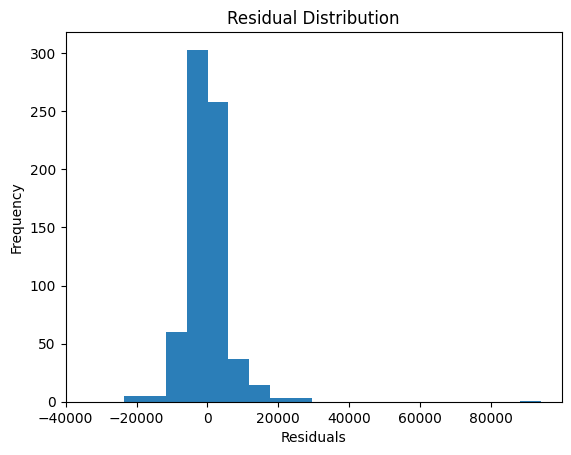

In [ ]:
plot_residuals(backwardModel.resid)